In [77]:
from datetime import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [78]:
%%script false --no-raise-error
filename = "../../../pylec/studies/data/Synthetic.Household.Profiles.h5"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df = pd.read_hdf(filename, "TimeSeries")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    houseinfo = pd.read_hdf(filename, "HouseInfo")
mask = (houseinfo.Country == "France") & (houseinfo.Nmonths == "12")
df = df.loc[:, [str(a) for a in houseinfo[mask].pdIndex.tolist()]]

df["Index"] = pd.date_range(
    start="01-01-2019 00:00:00", end="31-12-2019 23:45:00", freq="15T"
)
df.set_index("Index", drop=True, inplace=True)

# --------------------------------------------
dateparse = lambda x: datetime.strptime(x, '%Y%m%d:%H%M')
pv = pd.read_csv("Timeseries_44.931_4.896_SA_1kWp_crystSi_14_38deg_-3deg_2014_2015.csv",
                 parse_dates=[0], index_col=[0], header=8, skipfooter=13, engine='python',
                 date_parser=dateparse)
# P is in W for a 1kW PV so we just have to change it to kW to get the coef 
pv = pv[['P']] / 1000
pv.columns = ["pv_1kw"]
pv = pv.loc['2014-01-01 00:00:00':'2015-01-01 00:10:00', :]

# Shifting things by 11 min, but whatever.
pv['Index'] = pd.date_range(start='2019-01-01 00:00:00',
                            end='2020-01-01 00:00:00', freq='60T')
pv.set_index('Index', drop=True, inplace=True)

# Interpolating to get 15-min interval values
pv = pv.resample('15T').interpolate('time')
pv.drop(pv.tail(1).index, inplace=True)

# --------------------------------------------
df["pv_1kw"] = pv["pv_1kw"]
df.to_pickle("fr_quoilin_data_valence.pickle")

In [79]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.head()

,2000900,2000901,2000903,2000904,2000905,2000906,2000907,2000908,2000909,2000910,...,2001188,2001189,2001190,2001192,2001193,2001194,2001195,2001197,2001199,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.295204,0.327625,0.483190,0.687899,0.143035,0.221557,0.224354,0.348925,2.359406,0.116382,...,0.079687,0.757643,0.080509,0.546715,0.026350,0.145583,0.160894,0.079701,1.420406,0.0
2019-01-01 00:15:00,0.223572,0.519240,0.236277,0.976978,0.178788,0.245871,0.485754,0.131845,1.064770,0.102974,...,0.269552,1.211409,0.074367,0.528931,0.057051,0.128810,0.155660,0.113194,0.641011,0.0
2019-01-01 00:30:00,0.237445,0.397812,0.151005,0.742844,0.232710,0.277901,0.594242,0.080997,0.897831,0.068910,...,0.107144,1.195561,0.083457,0.640498,0.069793,0.086199,0.188493,0.086067,0.540511,0.0
2019-01-01 00:45:00,0.477201,0.397999,0.398284,0.587097,0.285982,0.267720,0.512216,0.141001,1.433766,0.063750,...,0.165818,1.145802,0.107888,0.544124,0.060159,0.079745,0.160131,0.068022,0.863154,0.0
2019-01-01 01:00:00,0.415664,0.275134,0.108359,0.789470,0.181792,0.258787,0.185333,0.127379,1.140404,0.069257,...,0.250045,1.544101,0.036674,0.560161,0.031038,0.084432,0.178843,0.090153,0.814874,0.0


In [80]:
co2_data = pd.read_pickle("complete_data_FR_CO2.pickle").loc[:, ["CO2_kg_kWh"]]
co2_data.head()

,CO2_kg_kWh
Index,
2019-01-01 00:00:00,0.05952
2019-01-01 00:15:00,0.05769
2019-01-01 00:30:00,0.05586
2019-01-01 00:45:00,0.05403
2019-01-01 01:00:00,0.05220


# Set study on 20 households

In [81]:
nb_houses = 20

In [82]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")
df.head()

Average consumption is 5.56 MWh


,2000989,2001197,2000914,2001123,2000964,2001189,2001111,2001179,2000909,2000918,...,2001107,2000913,2001139,2000960,2001149,2001165,2000954,2001114,2000926,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.420397,0.079701,0.857910,0.031886,0.181189,0.757643,0.190965,0.227143,2.359406,0.055817,...,0.070520,0.142502,0.255521,0.582962,0.180451,1.942729,3.863059,0.121460,0.469955,0.0
2019-01-01 00:15:00,0.545898,0.113194,1.250317,0.141971,0.137223,1.211409,0.093381,0.188724,1.064770,0.061609,...,0.088147,0.223753,0.345453,0.525038,0.200254,3.050416,5.486453,0.134062,0.684911,0.0
2019-01-01 00:30:00,0.434237,0.086067,1.391707,0.100812,0.145738,1.195561,0.059680,0.132277,0.897831,0.050262,...,0.114732,0.041090,0.326808,1.252299,0.226341,0.560178,4.171616,0.109371,0.762364,0.0
2019-01-01 00:45:00,0.282571,0.068022,1.058611,0.039150,0.292894,1.145802,0.157409,0.154381,1.433766,0.044647,...,0.140997,0.281691,0.546796,0.521619,0.218049,3.840278,3.296981,0.097153,0.579897,0.0
2019-01-01 01:00:00,0.269873,0.090153,0.930174,0.074543,0.215576,1.544101,0.051027,0.251023,1.140404,0.037189,...,0.085866,0.043304,0.188321,0.512975,0.145118,0.313930,4.377657,0.073465,0.317332,0.0


In [ ]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house20",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [84]:
df.describe().T[["mean", "min", "max"]]

,mean,min,max
2000989,0.642409,0.009760,15.452793
2001197,0.096313,0.002070,2.248960
2000914,1.527877,0.007914,73.415019
2001123,0.264018,0.010254,8.702582
2000964,0.569726,0.018387,17.223078
2001189,1.024281,0.014418,34.618334
2001111,0.446941,0.011408,9.133565
2001179,0.250011,0.008664,4.353821
2000909,1.084943,0.015853,23.098691
2000918,0.208345,0.004761,7.726401


In [85]:
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

In [86]:
df.head()

,pv_1kw,community_kW
Index,,
2019-01-01 00:00:00,0.0,12.930472
2019-01-01 00:15:00,0.0,15.765637
2019-01-01 00:30:00,0.0,12.099126
2019-01-01 00:45:00,0.0,14.475988
2019-01-01 01:00:00,0.0,10.696315


In [87]:
df["CO2_kg_kWh"] = co2_data["CO2_kg_kWh"]
df.head()

,pv_1kw,community_kW,CO2_kg_kWh
Index,,,
2019-01-01 00:00:00,0.0,12.930472,0.05952
2019-01-01 00:15:00,0.0,15.765637,0.05769
2019-01-01 00:30:00,0.0,12.099126,0.05586
2019-01-01 00:45:00,0.0,14.475988,0.05403
2019-01-01 01:00:00,0.0,10.696315,0.05220


# Data reduction method

In [88]:
import numpy as np
import pandas as pd
from scipy.cluster.vq import whiten, vq

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
from sklearn import preprocessing



class Clustering:
    """
    Class for simulation time period reduction using clustering
    (sklearn approach)
    """
    def __init__(self, data):
        """

        :param data: dataframe with at least the following columns
        [ cons_kw , coef_1kw ,   co2_kg_kwh ]
        """
        self.data = data
        self.observation_info = None

    def reshape_data(self, observation_size: int = 7,
                         pre_process: bool = True, freq="1D"):

        """
        Method to reshape process data into a numpy array of m * n shape
        :param observation_size: size of each observation (given in days)
        :param pre_process:  Boolean value to determine if the data for clustering should
        undergo pre processing
        :return: numpy array of m * n shape
        """

        if pre_process == True:

            data = preprocessing.minmax_scale(self.data.copy())
            data = pd.DataFrame(data, columns=self.data.columns, index=self.data.index)
        else:
            data = self.data.copy()
        ranges = pd.date_range(start=data.index[0].date(),
                               end=data.index[-1].date(), freq=freq)
        new_data = []
        observation_info = {}
        for i in range(len(ranges) - 1):
            if i + observation_size < len(ranges):
                new_data.append(data.loc[ranges[i]: ranges[i + observation_size]].copy().values)
                observation_info[i] = [ranges[i], ranges[i + observation_size]]
        new_data = np.array(new_data)

        shp = new_data.shape
        new_data = whiten(new_data)
        new_data = new_data.reshape(shp[0], shp[1] * shp[2])

        self.observation_info = observation_info
        # print (new_data.shape)
        return new_data

    def get_weights(self, data, centres, closest, n_clusters):
        """

        :param data: numpy array of m * n shape
        :param centres: list of  index of centroids
        :param closest: list of  index of selected observations
        :param n_clusters: number of clusters
        :return: dictionary of chosen observations and corresponding weights
        """
        coeff_norm = 52 / len(data)
        indx, _ = vq(data, centres)
        indx = np.bincount(indx).tolist()
        weights = {}

        for i in range(n_clusters):
            weights[closest[i]] = coeff_norm * indx[i]

        return weights

    def selected_clusters(self, closest):
        """

        :param closest: list of  index of selected observations
        :return: dataframe of selected observations
        """

        labels = self.observation_info
        df = pd.DataFrame()
        for value in closest:

            temp = self.data.loc[labels[value][0]: labels[value][1]].copy()
            temp["cluster"] = [value] * len(temp)

            if len(df) == 0:

                df = temp
            else:
                df = pd.concat([df, temp])

        return df

    def cluster(self, data, n_clusters):
        """

        :param data: numpy array of m * n shape
        :param n_clusters: number of clusters
        :return: dataframe of selected observations , dictionary of chosen
        observations and corresponding weights
        """

        kmeans = KMeans(n_clusters=n_clusters, init='k-means++',
                        n_init=42, max_iter=300, tol=1e-15).fit(data)
        centres = kmeans.cluster_centers_
        closest = pairwise_distances_argmin_min(centres, data)[0]

        clusters = self.selected_clusters(closest)
        weights = self.get_weights(data, centres, closest, n_clusters)

        return clusters, weights

    def make_pickle(self, df, filepath: str = "../../data/", file_name: str = "clustered_data_DE_.pickle"):
        """

        :param df: dataframe to be pickled
        :param filepath: directory where file is to be stored
        :param file_name: desired file name
        :return:
        """
        df.sort_index().to_pickle(filepath + file_name)

    def make_csv(self, df, filepath: str = "../../data/", file_name: str = "clustered_data_DE_.csv"):
        """

        :param df: dataframe to be pickled
        :param filepath: directory where file is to be stored
        :param file_name: desired file name
        :return:
        """
        df.sort_index().to_csv(filepath + file_name, sep=",", decimal='.', index=True)


comment %% to run KElbow method. Unclear if relevant.

In [89]:
%%script false --no-raise-error
#from yellowbrick.cluster import KElbowVisualizer

model = Clustering(df.copy())
reshaped_data = model.reshape_data(observation_size=1, freq="7D")  # observation_size=1, freq="7D"
test_model = KMeans(init='k-means++',n_init=42, max_iter=300, tol=1e-15)
visualizer = KElbowVisualizer(test_model, k=(2,30), timings=True)
visualizer.fit(reshaped_data)
visualizer.show() 

# Select right number of clusters

In [90]:
df.head()

,pv_1kw,community_kW,CO2_kg_kWh
Index,,,
2019-01-01 00:00:00,0.0,12.930472,0.05952
2019-01-01 00:15:00,0.0,15.765637,0.05769
2019-01-01 00:30:00,0.0,12.099126,0.05586
2019-01-01 00:45:00,0.0,14.475988,0.05403
2019-01-01 01:00:00,0.0,10.696315,0.05220


In [91]:
model = Clustering(df.copy())
reshaped_data = model.reshape_data(observation_size=1, freq="7D")  # observation_size=1, freq="7D"
nb_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
all_clusters = {}

for n_cluster in nb_clusters:
    clusters, weights = model.cluster(data=reshaped_data, n_clusters=n_cluster)
    clusters["weight"] = clusters.cluster.apply(lambda x: weights[x])
    
    # Scale to same energy consumption, pv production, and CO2 emissions
    tmp = clusters.copy()
    tmp["community_kW"] *= tmp["weight"]
    tmp["pv_1kw"] *= tmp["weight"]
    tmp["CO2_kg_kWh"] *= tmp["weight"]
    
    cons_coef = df['community_kW'].sum() / tmp['community_kW'].sum()
    prod_coef = df['pv_1kw'].sum() / tmp['pv_1kw'].sum()
    co2_coef = df['CO2_kg_kWh'].sum() / tmp['CO2_kg_kWh'].sum()
    print(f"{n_cluster} -> {round(cons_coef, 3)}, {round(prod_coef, 3)}, {round(co2_coef, 3)}")

    clusters["community_kW"] *= cons_coef
    clusters["pv_1kw"] *= prod_coef
    clusters["CO2_kg_kWh"] *= co2_coef
    
    all_clusters[n_cluster] = clusters.copy()

2 -> 1.058, 0.766, 1.076


/Users/jonathan/virtualenvs/jonathan/lib/python3.8/site-packages/scipy/cluster/vq.py:135: RuntimeWarning:

Some columns have standard deviation zero. The values of these columns will not change.



3 -> 1.048, 1.034, 0.997
4 -> 1.036, 0.994, 1.077
5 -> 0.992, 1.094, 1.059
6 -> 1.0, 1.002, 1.011
7 -> 1.007, 0.997, 1.017
8 -> 0.998, 1.005, 1.006
9 -> 1.016, 1.003, 1.011
10 -> 1.009, 1.036, 1.006


In [92]:
pv_max = 5

## Self-sufficiency no battery check

In [93]:
def self_consumption_production(df, cons_col, prod_col, timing):
    """Return self-consumption and self-production in %"""
    result = {}
    local = df[[cons_col, prod_col]].groupby(pd.Grouper(freq=timing)).sum().min(axis=1).sum()  # unit do not matter
    result[f"self_cons"] = local * 100 / df[prod_col].sum()
    result[f"self_prod"] = local * 100 / df[cons_col].sum()
    return result

### Reference

In [94]:
pv_sizes = list(np.linspace(0.01, pv_max, 100))
self_prod = []

for pv_size in pv_sizes:
    graph = df.copy()
    graph.pv_1kw *= nb_houses * pv_size
    res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing="15T")
    self_prod.append(res['self_prod'])
reference = pd.DataFrame(index=pv_sizes, data={"reference": self_prod})

### Clusters

In [95]:
pv_sizes = list(np.linspace(0.01, pv_max, 100))
self_prod = {}
self_cons = {}
    
for n_cluster in nb_clusters:
    self_prod[n_cluster] = []
    self_cons[n_cluster] = []
    
    tmp = all_clusters[n_cluster].copy()
    tmp["community_kW"] *= tmp["weight"]
    tmp["pv_1kw"] *= tmp["weight"]
    
    for pv_size in pv_sizes:
        graph = tmp.copy()
        graph.pv_1kw *= nb_houses * pv_size
        res = self_consumption_production(graph, cons_col="community_kW", prod_col="pv_1kw", timing="15T")
        self_prod[n_cluster].append(res['self_prod'])
        self_cons[n_cluster].append(res['self_cons'])

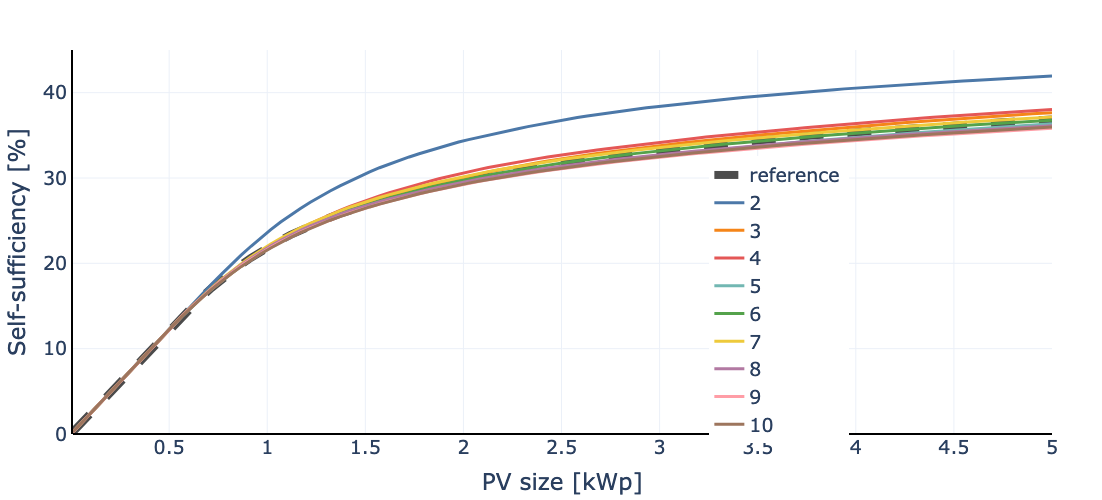

In [96]:
_fig_self = px.line(reference)
_fig_self.update_traces(line_color="black", line_width=8, opacity=0.7, line_dash="dash")

graph = pd.DataFrame(index=pv_sizes, data=self_prod)
scores = []
for col in graph.columns:
    score = (graph[col] - reference.reference).abs().sum() * 100 / reference.reference.abs().sum()
    scores.append(score)
    # print(f"cluster {col} -> score={np.round(score, 3)}")
scores = pd.DataFrame(index=graph.columns, data=scores)

for trace in px.line(graph).data:
    _fig_self.add_trace(trace)
    _fig_self.data[-1].update(line_width=3)

_fig_self.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Self-sufficiency [%]",
    yaxis_dtick=10,
    xaxis_title="PV size [kWp]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[0, 45],
    showlegend=True,
    legend={"x": 0.65, "y": 0.35},
    legend_title="")
_fig_self.show()

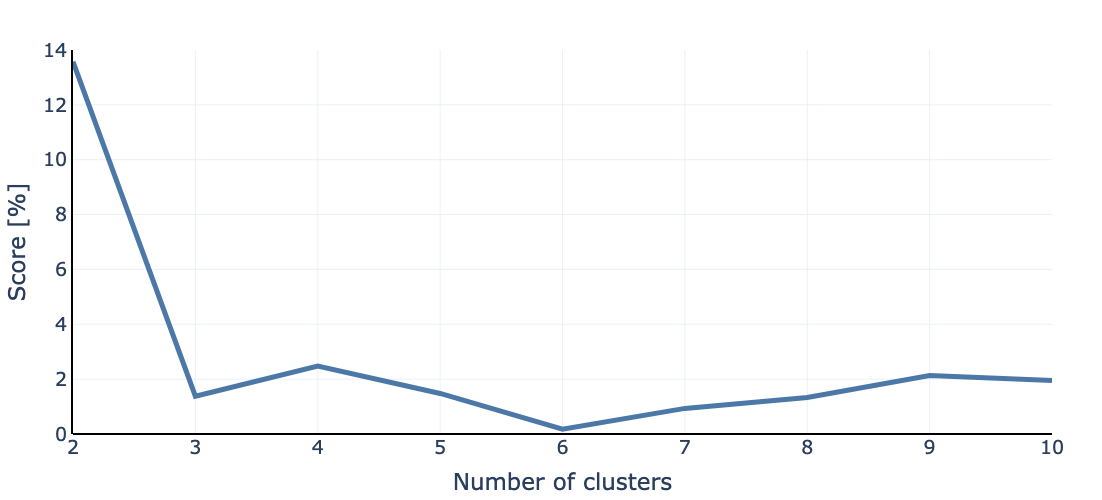

In [97]:
_fig = px.line(scores)
_fig.update_traces(line_width=5)
_fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Score [%]",
    xaxis_title="Number of clusters",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[0, 14],
    showlegend=False
)
_fig.show()

## Self-sufficiency with battery

In [98]:
df.head()

,pv_1kw,community_kW,CO2_kg_kWh
Index,,,
2019-01-01 00:00:00,0.0,12.930472,0.05952
2019-01-01 00:15:00,0.0,15.765637,0.05769
2019-01-01 00:30:00,0.0,12.099126,0.05586
2019-01-01 00:45:00,0.0,14.475988,0.05403
2019-01-01 01:00:00,0.0,10.696315,0.05220


In [99]:
def def1_self_production(df, cons_col, prod_col, storage):
    """
    Defintion 1: Merge storage in production.
    """
    result = {}
    _df = df.copy()
    _df["prod_before_storage"] = _df[prod_col]
    _df[prod_col] = _df[prod_col] - _df[storage]
    
    local = _df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter 
    result[f"self_prod"] = local * 100 / _df[cons_col].sum()
    result[f"self_cons"] = local * 100 / _df["prod_before_storage"].sum()
    return result

In [100]:
def best_course_action(cons, prod):
    in_kw = prod - cons
    return in_kw

def battery_constraints(in_kw, soc_kwh, spec, deltat=15):
    # Energy
    offset = spec["max_kwh"] * spec["offset"]
    max_charg_kW = max(
        0, (spec["max_kwh"] - offset - soc_kwh) / (spec["eta"] * deltat / 60)
    )
    if in_kw > max_charg_kW:
        in_kw = max_charg_kW

    max_discharg_kW = min(0, (0 + offset - soc_kwh) * spec["eta"] / (deltat / 60))
    if in_kw < max_discharg_kW:
        in_kw = max_discharg_kW

    # Power
    if in_kw > spec["max_kw"]:
        in_kw = spec["max_kw"]

    if in_kw < -spec["min_kw"]:
        in_kw = -spec["min_kw"]
    return in_kw

def update_soc(in_kw, previous_soc_kwh, spec, deltat=15):
    # Power
    assert in_kw <= spec["max_kw"], f"{in_kw} <= {spec['max_kw']}"
    assert in_kw >= -spec["min_kw"], f"{in_kw} >= {-spec['min_kw']}"

    # Energy
    if in_kw > 0:
        _eta = spec["eta"]
    else:
        _eta = 1 / spec["eta"]
    new_soc_kwh = previous_soc_kwh + _eta * in_kw * deltat / 60
    assert new_soc_kwh <= spec["max_kwh"], f"{new_soc_kwh}"
    assert new_soc_kwh >= 0, f"{new_soc_kwh}"
    return new_soc_kwh

def individual_storage_control(df, cons_col, prod_col, storage_col, soc_col, spec):
    in_kws = [0]
    soc_kwhs = [0]
    
    for cons, prod in zip(df[cons_col], df[prod_col]):
        in_kw = best_course_action(cons, prod)
        in_kw = battery_constraints(in_kw, soc_kwhs[-1], spec)
        in_kws.append(in_kw)
        soc_kwhs.append(update_soc(in_kw, soc_kwhs[-1], spec))
    
    del in_kws[0]    
    del soc_kwhs[0]
    df[storage_col] = in_kws
    df[soc_col] = soc_kwhs
    return df

### Reference

In [101]:
pv_sizes = list(np.linspace(0.01, pv_max, 100))
battery_size = 3
self_prod = []

spec = {"min_kw": nb_houses * battery_size / 2,
        "max_kw": nb_houses * battery_size / 2,
        "max_kwh": nb_houses * battery_size,
        "eta": 0.95,
        "offset": 0.01}

for pv_size in pv_sizes:
    graph = df.copy()
    graph.pv_1kw *= nb_houses * pv_size
    graph = individual_storage_control(graph, "community_kW", "pv_1kw", "storage", "soc", spec)

    res = def1_self_production(graph, cons_col="community_kW", prod_col="pv_1kw", storage="storage")
    self_prod.append(res['self_prod'])
reference = pd.DataFrame(index=pv_sizes, data={"reference": self_prod})

### Clusters

In [102]:
pv_sizes = list(np.linspace(0.01, pv_max, 100))
self_prod = {}
self_cons = {}
    
for n_cluster in nb_clusters:
    self_prod[n_cluster] = []
    self_cons[n_cluster] = []
    
    for pv_size in pv_sizes:
        graph = all_clusters[n_cluster].copy()
        
        graph.pv_1kw *= nb_houses * pv_size
        graph = individual_storage_control(graph, "community_kW", "pv_1kw", "storage", "soc", spec)       
        
        graph["community_kW"] *= graph["weight"]
        graph["pv_1kw"] *= graph["weight"]
        graph["storage"] *= graph["weight"]
        
        res = def1_self_production(graph, cons_col="community_kW", prod_col="pv_1kw", storage="storage")
        self_prod[n_cluster].append(res['self_prod'])
        self_cons[n_cluster].append(res['self_cons'])

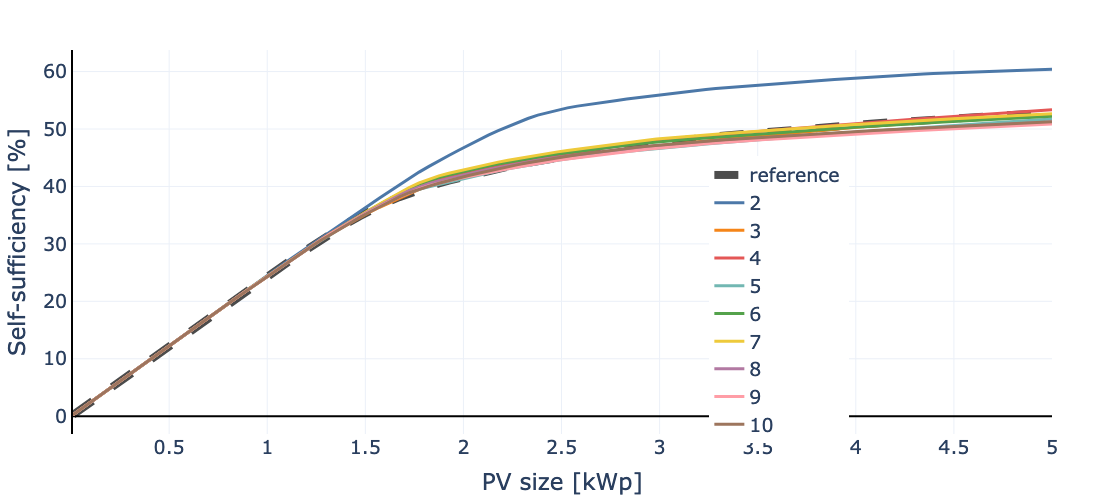

In [103]:
_fig_self = px.line(reference)
_fig_self.update_traces(line_color="black", line_width=8, opacity=0.7, line_dash="dash")

graph = pd.DataFrame(index=pv_sizes, data=self_prod)
scores = []
for col in graph.columns:
    score = (graph[col] - reference.reference).abs().sum() * 100 / reference.reference.abs().sum()
    scores.append(score)
    # print(f"cluster {col} -> score={np.round(score, 3)}")
scores = pd.DataFrame(index=graph.columns, data=scores)

for trace in px.line(graph).data:
    _fig_self.add_trace(trace)
    _fig_self.data[-1].update(line_width=3)

_fig_self.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Self-sufficiency [%]",
    yaxis_dtick=10,
    xaxis_title="PV size [kWp]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    #yaxis_range=[0, 65],
    showlegend=True,
    legend={"x": 0.65, "y": 0.35},
    legend_title="")
_fig_self.show()

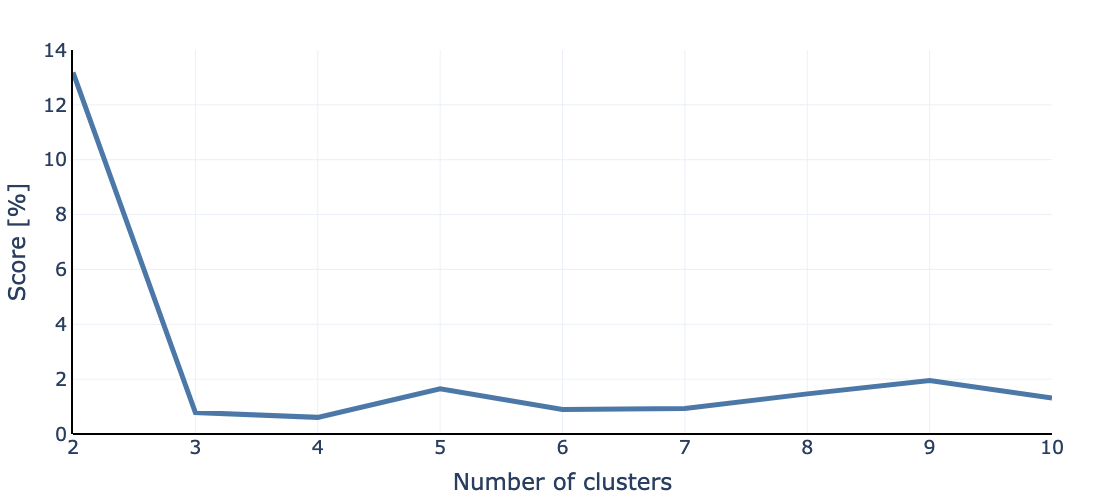

In [104]:
_fig = px.line(scores)
_fig.update_traces(line_width=5)
_fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Score [%]",
    xaxis_title="Number of clusters",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    yaxis_range=[0, 14],
    showlegend=False
)
_fig.show()

## CO2

In [105]:
df.head()

,pv_1kw,community_kW,CO2_kg_kWh
Index,,,
2019-01-01 00:00:00,0.0,12.930472,0.05952
2019-01-01 00:15:00,0.0,15.765637,0.05769
2019-01-01 00:30:00,0.0,12.099126,0.05586
2019-01-01 00:45:00,0.0,14.475988,0.05403
2019-01-01 01:00:00,0.0,10.696315,0.05220


In [106]:
df.CO2_kg_kWh.mean()

0.05848144748858447

In [107]:
(df.community_kW * df.CO2_kg_kWh).sum() / df.community_kW.sum()

0.05773272663452952

In [108]:
def average_co2_per_kwh(df, cons_col, prod_col, co2_col):
    """Return CO2 per kWh on average"""
    grid_import = df[cons_col] - df[[cons_col, prod_col]].min(axis=1)
    return (grid_import * df[co2_col]).sum() / df[cons_col].sum()

### Reference

In [109]:
pv_sizes = list(np.linspace(0.01, pv_max, 100))
self_prod = []

for pv_size in pv_sizes:
    graph = df.copy()
    graph.pv_1kw *= nb_houses * pv_size
    res = average_co2_per_kwh(graph, cons_col="community_kW", prod_col="pv_1kw", co2_col="CO2_kg_kWh")
    self_prod.append(res)
reference = pd.DataFrame(index=pv_sizes, data={"reference": self_prod})

### Clusters

In [110]:
pv_sizes = list(np.linspace(0.01, pv_max, 100))
self_prod = {}
    
for n_cluster in nb_clusters:
    self_prod[n_cluster] = []
    
    tmp = all_clusters[n_cluster].copy()
    tmp["community_kW"] *= tmp["weight"]
    tmp["pv_1kw"] *= tmp["weight"]
    
    for pv_size in pv_sizes:
        graph = tmp.copy()
        graph.pv_1kw *= nb_houses * pv_size
        res = average_co2_per_kwh(graph, cons_col="community_kW", prod_col="pv_1kw", co2_col="CO2_kg_kWh")
        self_prod[n_cluster].append(res)

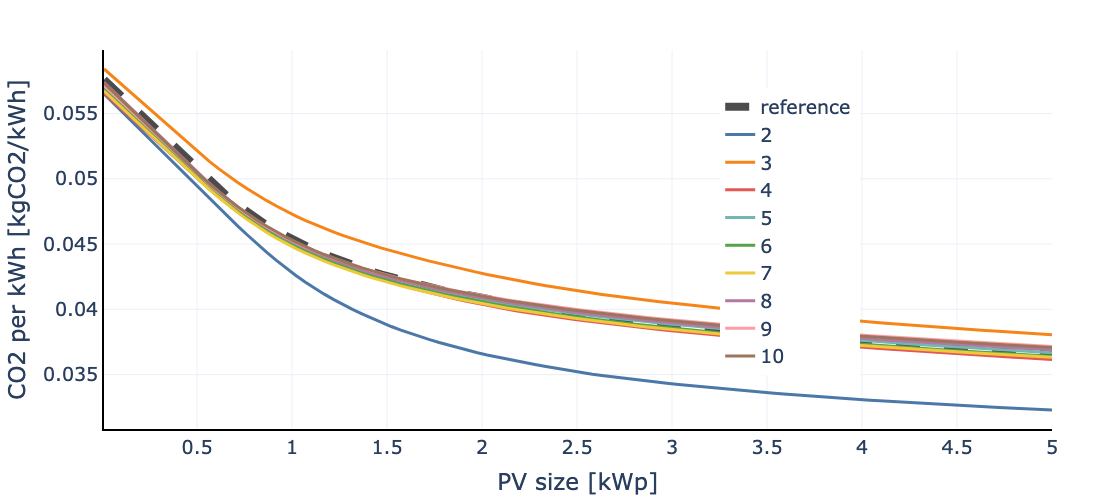

In [111]:
_fig_self = px.line(reference)
_fig_self.update_traces(line_color="black", line_width=8, opacity=0.7, line_dash="dash")

graph = pd.DataFrame(index=pv_sizes, data=self_prod)
scores = []
for col in graph.columns:
    score = (graph[col] - reference.reference).abs().sum() * 100 / reference.reference.abs().sum()
    scores.append(score)
    # print(f"cluster {col} -> score={np.round(score, 3)}")
scores = pd.DataFrame(index=graph.columns, data=scores)

for trace in px.line(graph).data:
    _fig_self.add_trace(trace)
    _fig_self.data[-1].update(line_width=3)

_fig_self.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="CO2 per kWh [kgCO2/kWh]",
    #yaxis_dtick=10,
    xaxis_title="PV size [kWp]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    #yaxis_range=[0, 45],
    showlegend=True,
    legend={"x": 0.65, "y": 0.9},
    legend_title="")
_fig_self.show()

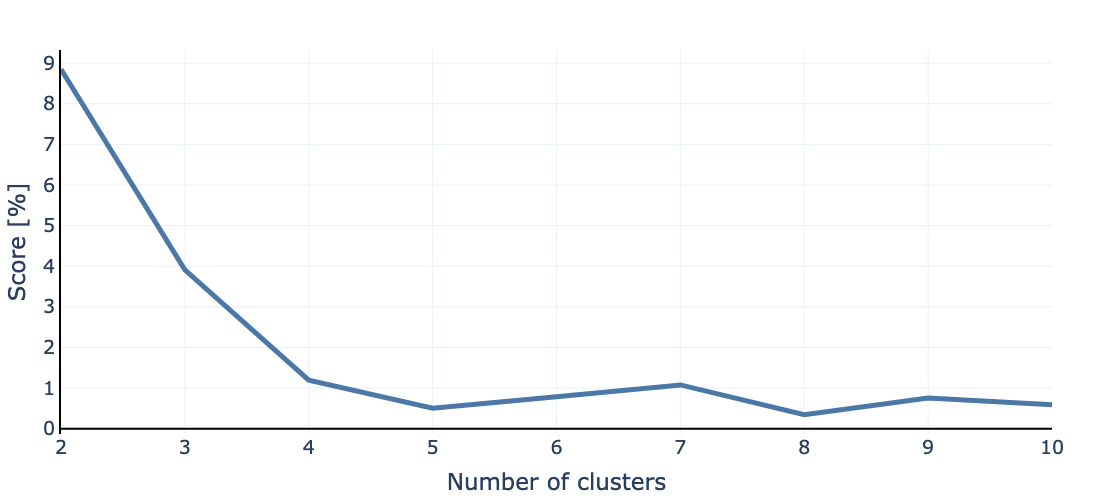

In [112]:
_fig = px.line(scores)
_fig.update_traces(line_width=5)
_fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Score [%]",
    xaxis_title="Number of clusters",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    #yaxis_range=[0, 14],
    showlegend=False
)
_fig.show()

# Run Carbon minimization on cluster

## Select best cluster

In [113]:
best_nb_clusters = 5

In [114]:
all_clusters[best_nb_clusters].head()

,pv_1kw,community_kW,CO2_kg_kWh,cluster,weight
Index,,,,,
2019-08-06 00:00:00,0.0,3.756208,0.065758,31,15.0
2019-08-06 00:15:00,0.0,5.240087,0.064810,31,15.0
2019-08-06 00:30:00,0.0,4.413718,0.063862,31,15.0
2019-08-06 00:45:00,0.0,6.561264,0.062914,31,15.0
2019-08-06 01:00:00,0.0,7.066393,0.061966,31,15.0


In [115]:
all_clusters[best_nb_clusters].groupby("cluster").head(1).sort_index()

,pv_1kw,community_kW,CO2_kg_kWh,cluster,weight
Index,,,,,
2019-02-12,0.0,21.669014,0.048882,6,10.0
2019-04-23,0.0,13.174535,0.025246,16,11.0
2019-08-06,0.0,3.756208,0.065758,31,15.0
2019-11-05,0.0,8.347550,0.059412,44,9.0
2019-11-19,0.0,8.814284,0.043998,46,7.0


In [116]:
clusters = all_clusters[best_nb_clusters].sort_index().copy()
clusters.head()

,pv_1kw,community_kW,CO2_kg_kWh,cluster,weight
Index,,,,,
2019-02-12 00:00:00,0.0,21.669014,0.048882,6,10.0
2019-02-12 00:15:00,0.0,18.892588,0.048776,6,10.0
2019-02-12 00:30:00,0.0,9.503370,0.048670,6,10.0
2019-02-12 00:45:00,0.0,9.350020,0.048564,6,10.0
2019-02-12 01:00:00,0.0,11.594275,0.048458,6,10.0


In [117]:
print(f"Actual consumption = {round(df['community_kW'].sum() /4, 3)} kWh")
print(f"New consumption = {round((clusters.weight * clusters['community_kW']).sum() /4, 3)} kWh")

Actual consumption = 111124.6 kWh
New consumption = 111124.6 kWh


## Optimization definition

In [118]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
import itertools


def optimize(
    data,
    period_coefs,
    battery_eta,
    pv_gwp,
    battery_gwp,
    positiv_coefs,
    self_sufficiency,
    soh_coefs,
    pv_ageing_coefs,
    solver="glpk",
    verbose=False,
    solver_path=None,
):
    """Optimization model"""
    ################### Model
    m = ConcreteModel()
    timestep = 15 / 60
    nb_years = 20

    ###################################################### Set
    m.years = Set(initialize=list(range(0, nb_years)), ordered=True)
    m.periods = Set(initialize=list(range(0, len(data))), ordered=True)
    m.times = Set(initialize=list(range(0, len(data[0]))), ordered=True)
    last = m.times.last()

    ##################################################### Var
    m.pv_capacity = Var(domain=NonNegativeReals)
    m.battery_cap = Var(m.years, domain=NonNegativeReals)
    m.co2_emission = Var(domain=NonNegativeReals)

    # Equipment specifics
    m.gridimport = Var(m.years, m.periods, m.times, domain=NonNegativeReals)
    m.batteryin = Var(m.years, m.periods, m.times, domain=NonNegativeReals)
    m.batteryout = Var(m.years, m.periods, m.times, domain=NonNegativeReals)
    m.batteryenergy = Var(m.years, m.periods, m.times, domain=NonNegativeReals)
    m.pv_curtailed = Var(m.years, m.periods, m.times, domain=NonNegativeReals)

    #################################################### Param
    m.self_sufficiency = Param(initialize=self_sufficiency)
    m.pv_gwp = Param(initialize=pv_gwp)
    m.battery_gwp = Param(initialize=battery_gwp)
    soh_coefs = list(itertools.chain.from_iterable([soh_coefs for i in range(3)]))

    #################################################### Rules
    # --------------------------------------------------------
    # ---------------------Battery----------------------------
    # --------------------------------------------------------
    def r_battery_max_powerin(m, y, p, t):
        return m.batteryin[y, p, t] <= m.battery_cap[y] / 2

    def r_battery_max_powerout(m, y, p, t):
        return m.batteryout[y, p, t] <= m.battery_cap[y] / 2

    def r_battery_energy(m, y, p, t):
        if t == 0:
            return m.batteryenergy[y, p, t] == m.batteryenergy[y, p, last]
        else:
            return (
                m.batteryenergy[y, p, t]
                == m.batteryenergy[y, p, t - 1]
                + m.batteryin[y, p, t - 1]  # * (1 - 1e-6)+  # avoid oscillations between pv curtailed and battery
                * timestep
                * battery_eta
                - m.batteryout[y, p, t - 1] * timestep / battery_eta
            )

    def r_battery_capacity_yearly(m, y):
        if y == 0:
            return Constraint.Skip
        elif y < 8:
            return m.battery_cap[0] * soh_coefs[y] == m.battery_cap[y]
        elif y == 8:
            return Constraint.Skip
        elif y < 16:
            return m.battery_cap[8] * soh_coefs[y] == m.battery_cap[y]
        elif y == 16:
            return Constraint.Skip
        elif y > 16:
            return m.battery_cap[16] * soh_coefs[y] == m.battery_cap[y]

    def r_battery_min_energy(m, y, p, t):
        return m.batteryenergy[y, p, t] >= m.battery_cap[y] * 0.2

    def r_battery_max_energy(m, y, p, t):
        return m.batteryenergy[y, p, t] <= m.battery_cap[y]

    def r_battery_charge_limit(m, y, p, t):
        return (m.batteryin[y, p, t] <= m.pv_capacity * data[p]['coef_1kw'][t] * pv_ageing_coefs[y])

    # --------------------------------------------------------
    # ------------------Grid imports--------------------------
    # --------------------------------------------------------
    def r_grid_import(m, y, p, t):
        return (
            m.gridimport[y, p, t]
            == positiv_coefs[y] * data[p]["cons_kw"][t]
            - m.pv_capacity * data[p]["coef_1kw"][t] * pv_ageing_coefs[y]
            + m.pv_curtailed[y, p, t]
            + m.batteryin[y, p, t]
            - m.batteryout[y, p, t]
        )

    def r_pv_curtailed(m, y, p, t):
        return m.pv_curtailed[y, p, t] <= m.pv_capacity * data[p]["coef_1kw"][t] * pv_ageing_coefs[y]

    def r_self_suff(m):
        return (
            sum(sum(sum(m.gridimport[y, p, t] for t in m.times) for p in m.periods) for y in m.years)
            / sum(
                sum(sum(positiv_coefs[y] * data[p]["cons_kw"][t] for t in m.times) for p in m.periods) for y in m.years
            )
            == 1 - m.self_sufficiency
        )

    def r_emission(m):
        return (
            m.pv_gwp * m.pv_capacity
            + m.battery_gwp * sum([m.battery_cap[0] + m.battery_cap[8] + m.battery_cap[16] / 2])
            + sum(
                sum(
                    period_coefs[p] * sum(m.gridimport[y, p, t] * data[p]["co2_kg_kwh"][t] * timestep for t in m.times)
                    for p in m.periods
                )
                for y in m.years
            )
        ) == m.co2_emission

    # --------------------------------------------------------
    # ---------------------Add To Model-----------------------
    # --------------------------------------------------------
    # Battery
    m.r1 = Constraint(m.years, m.periods, m.times, rule=r_battery_max_powerin)
    m.r2 = Constraint(m.years, m.periods, m.times, rule=r_battery_max_powerout)
    m.r3 = Constraint(m.years, m.periods, m.times, rule=r_battery_energy)
    m.r4 = Constraint(m.years, m.periods, m.times, rule=r_battery_min_energy)
    m.r5 = Constraint(m.years, m.periods, m.times, rule=r_battery_max_energy)
    m.r6 = Constraint(m.years, m.periods, m.times, rule=r_battery_charge_limit)
    m.r7 = Constraint(m.years, rule=r_battery_capacity_yearly)

    # Grid imports
    m.r8 = Constraint(m.years, m.periods, m.times, rule=r_grid_import)
    m.r9 = Constraint(m.years, m.periods, m.times, rule=r_pv_curtailed)
    m.r10 = Constraint(rule=r_self_suff)
    m.r11 = Constraint(rule=r_emission)

    ##################################################### Objective function
    # Linear objective function
    def objective_function(m):
        return m.co2_emission

    m.objective = Objective(rule=objective_function, sense=minimize)

    #################################################### Run
    # Solve optimization problem
    with SolverFactory(solver, executable=solver_path) as opt:
        results = opt.solve(m, tee=False)
        if verbose:
            print(results)
    return m


In [119]:
def post_process(model, data, period_coefs, yearly_cons_mwh, verbose=True):
    result = {}
    result = _get_pyomo_timeseries(result, model, [d.index for d in data])
    result["yearly_cons_mwh"] = yearly_cons_mwh
    result["nb_years"] = model.years.data()[-1] + 1

    # Self-sufficiency
    result["self_sufficiency"] = model.self_sufficiency.value * 100

    # Total carbon emissions
    timestep = 15 / 60
    nb_years = result["nb_years"]
    result["co2_kg_mwh_not_discounted"] = np.round(model.co2_emission.value / (yearly_cons_mwh * nb_years), 2)
    result["co2_kg_not_discounted"] = np.round(model.co2_emission.value, 2)

    # Total carbon emissions counting PV export as negative
    discounted_pv = sum(
        sum(
            period_coefs[p]
            * sum(model.pv_curtailed[y, p, t].value * data[p]["co2_kg_kwh"][t] * timestep for t in model.times)
            for p in model.periods
        )
        for y in model.years
    )
    result["co2_kg_mwh"] = np.round((model.co2_emission.value - discounted_pv) / (yearly_cons_mwh * nb_years), 2)
    result["co2_kg"] = np.round(model.co2_emission.value - discounted_pv, 2)

    # Battery and PV sizes
    result["pv_capacity"] = np.round(model.pv_capacity.value, 2)
    result["pv_capacity_yearlymwh"] = np.round(model.pv_capacity.value / yearly_cons_mwh, 2)

    df = pd.DataFrame(index=["_"], data=getattr(model, "battery_cap").get_values())
    df = df.transpose()
    result["battery_cap"] = df["_"].to_list()
    result["battery_kwh"] = [np.round(result["battery_cap"][year], 2) for year in [0, 8, 16]]
    result["battery_kwh_yearlymwh"] = [np.round(result["battery_cap"][year] / yearly_cons_mwh, 2) for year in [0, 8, 16]]

    # CAPEX side of the emissions
    result["capex"] = np.round(
        (
            model.pv_gwp.value * model.pv_capacity.value
            + model.battery_gwp
            * sum([result["battery_cap"][0] + result["battery_cap"][1] + result["battery_cap"][2] / 2])
        ), 2
    )
    result["capex_yearlymwh"] = round(result["capex"] / yearly_cons_mwh)

    # OPEX
    # OPEX = co2_kg_not_discounted - capex

    if verbose:
        print(f'Self-sufficiency   = {result["self_sufficiency"]} %')
        print(f'Yearly cons. mwh   = {np.round(yearly_cons_mwh/20, 2)} MWh/house')
        print(f'CO2 emission       = {result["co2_kg_mwh_not_discounted"]} kgCO2eq/MWh')
        print(f'CO2 emission disc. = {result["co2_kg_mwh"]} kgCO2eq/MWh')
        print(f'PV capacity        = {result["pv_capacity_yearlymwh"]} kWp/yearlyMWh')
        print(f'Battery capacity   = {result["battery_kwh_yearlymwh"]} kWh/yearlyMWh')
        print(f'CO2 CAPEX          = {result["capex"]} kgCO2eq')
        print(f'CO2 OPEX           = {result["co2_kg_not_discounted"] - result["capex"]} kgCO2eq')
    return result

def post_process_keys():
    return ["yearly_cons_mwh", "nb_years", "co2_kg_mwh_not_discounted",
            "co2_kg_not_discounted", "co2_kg_mwh", "co2_kg", "pv_capacity", "pv_capacity_yearlymwh",
            "battery_kwh", "battery_kwh_yearlymwh", "capex", "capex_yearlymwh"]

def _get_pyomo_timeseries(result, model, indexes):
    """Custom function to retrive optimization timeseries from `base.py`"""
    keys = ["gridimport", "pv_curtailed", "batteryin", "batteryout", "batteryenergy"]
    nb_years = model.years.data()[-1] + 1
    nb_periods = model.periods.data()[-1] + 1

    for key in keys:
        df = pd.DataFrame(index=["_"], data=getattr(model, key).get_values())
        df = df.transpose()
        df.columns = [key]
        result[key] = []
        for year in range(0, nb_years):
            result[key].append([])
            for period in range(0, nb_periods):
                result[key][-1].append(df.loc[year, period, :, :].copy())
                result[key][-1][-1].index = indexes[period]
    return result

## Run for all self-sufficiency cluster

In [120]:
clusters.head()

,pv_1kw,community_kW,CO2_kg_kWh,cluster,weight
Index,,,,,
2019-02-12 00:00:00,0.0,21.669014,0.048882,6,10.0
2019-02-12 00:15:00,0.0,18.892588,0.048776,6,10.0
2019-02-12 00:30:00,0.0,9.503370,0.048670,6,10.0
2019-02-12 00:45:00,0.0,9.350020,0.048564,6,10.0
2019-02-12 01:00:00,0.0,11.594275,0.048458,6,10.0


In [121]:
clusters.columns = ["coef_1kw", "cons_kw", "co2_kg_kwh", "cluster", "weight"]

In [123]:
from copy import deepcopy
import pickle

subset = {}
self_sufficiencies = [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 75, 80.0, 85, 90.0, 95, 98, 100.0]
self_sufficiencies = [25]
self_sufficiencies = [a / 100 for a in self_sufficiencies]


yearly_cons_mwh = (clusters.weight * clusters.cons_kw).sum() / 4 / 1000
positive_feedback = 1
soh = [1.0*0.93**n for n in range(8)]
pv_ageing = [1 - 0.005 * i for i in range(20)]
postive_feedback = [1.0*positive_feedback**n for n in range(0, 20)]

data = []
for _, frame in clusters.groupby("cluster"):
    data.append(frame.copy())

for self_sufficiency in self_sufficiencies:
    inputs = {
        'pv_gwp': 1040/2,  # kgCo2/kW
        'battery_gwp': 158,  # kgCO2/kWh, lifetime = 8 years (4 years discounted)
        'self_sufficiency': self_sufficiency,
        "period_coefs": clusters.groupby("cluster").head(1).weight.tolist(),
        'battery_eta': 0.95,
        "soh_coefs": soh,
        "pv_ageing_coefs": pv_ageing,
        "positiv_coefs": postive_feedback
    }

    # Run
    model = optimize(data, **inputs, verbose=False, solver="gurobi")
    result = post_process(model, data, inputs["period_coefs"], yearly_cons_mwh)
    print("---")
    print("   ")

    # Save
    subset[self_sufficiency] = {}
    for col in post_process_keys():
        subset[self_sufficiency][col] = deepcopy(result[col])
    subset[self_sufficiency]["pv_curtailed"] = deepcopy(getattr(model, "pv_curtailed").get_values())
    subset[self_sufficiency]["period_coefs"] = deepcopy(inputs["period_coefs"])
    subset[self_sufficiency]["data"] = data.copy()
    subset[self_sufficiency]["years"] = list(getattr(model, "years").data())
    subset[self_sufficiency]["periods"] = list(getattr(model, "periods").data())
    subset[self_sufficiency]["times"] = list(getattr(model, "times").data())
    with open('subset_FR.pickle', 'wb') as handle:
        pickle.dump(subset, handle, protocol=pickle.HIGHEST_PROTOCOL)

Self-sufficiency   = 25.0 %
Yearly cons. mwh   = 5.56 MWh/house
CO2 emission       = 49.71 kgCO2eq/MWh
CO2 emission disc. = 43.04 kgCO2eq/MWh
PV capacity        = 0.3 kWp/yearlyMWh
Battery capacity   = [0.0, 0.0, 0.01] kWh/yearlyMWh
CO2 CAPEX          = 17129.89 kgCO2eq
CO2 OPEX           = 93346.46 kgCO2eq
---
   


In [ ]:
import pickle 

with open('subset_FR_520.pickle', 'rb') as handle:
    subset = pickle.load(handle)

In [ ]:
index = list(subset.keys())
graph = pd.DataFrame(index=index, data=[subset[i]["co2_kg_mwh_not_discounted"] for i in index])
graph.index *= 100

text = []
mwh_per_house = subset[0.0]["yearly_cons_mwh"] / 20
for i in index:
    text.append(f"""
{np.round(subset[i]['pv_capacity_yearlymwh'] * mwh_per_house, 2)}kWp/house & 
{round(np.mean(subset[i]['battery_kwh_yearlymwh']) * mwh_per_house, 2)}kWh/house
""")

text = [a.replace("\n", "") for a in text]
graph["text"] = text

_fig = px.line(graph, hover_data=["text"])

_fig.add_shape(
  type='line',
  x0=1, x1=99,
  y0=subset[0.0]["co2_kg_mwh_not_discounted"],
  y1=subset[0.0]["co2_kg_mwh_not_discounted"],
  line={'dash': 'dash', 'width': 4,
        'color': 'rgba(214, 39, 40, 0.9)'})

_fig.update_traces(line_width=5)
_fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="GHG [kgCO<sub>2</sub>eq / MWh]",
    xaxis_title="Self-sufficiency [%]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_dtick=10,
    #yaxis_range=[0, 14],
    showlegend=False
)
_fig.show()

In [ ]:
_fig.write_image("results/FR_basic_curve_520.svg")

In [ ]:
data = {}
index = list(subset.keys())
for reduction in [0.2, 0.5, 0.8, 1.0]:
    data[f"reduction={reduction}"] = []
    
    for i in index:
        # Total carbon emissions counting PV export as negative
        timestep = 15 / 60
        discounted_pv = sum(
            sum(
                subset[i]["period_coefs"][p]
                * sum(subset[i]["pv_curtailed"][(y, p, t)] * reduction * subset[i]["data"][p]["co2_kg_kwh"][t] * timestep for t in subset[i]["times"])
                for p in subset[i]["periods"]
            )
            for y in subset[i]["years"]
        )
        result = np.round((subset[i]["co2_kg_not_discounted"] - discounted_pv) / (subset[0.9]["yearly_cons_mwh"] * subset[0.9]["nb_years"]), 2)
        data[f"reduction={reduction}"].append(result)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(_fig)
#fig.update_traces(line_color="black")

graph = pd.DataFrame(index=index, data=data)
graph.drop(0.98, axis=0, inplace=True)
graph.index *= 100

for trace in px.line(graph).data:
    fig.add_trace(trace)
    fig.data[-1].update(line_width=3, line_color="grey")
    fig.layout.update(
    height=600,
    width=800,
    yaxis_title="GHG [kgCO<sub>2</sub>eq / MWh]",
    xaxis_title="Self-sufficiency [%]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_dtick=10,
    #yaxis_range=[0, 14],
    showlegend=False)
fig.show()

In [ ]:
fig.write_image("results/FR_discount_curve_520.svg")